# Adaboost 模型预测

#### 之前使用了 DecisionTree 决策树模型，原本是希望在后面直接对比检测 Adaboost 模型的效果，但是程序报错，分析有以下几个问题：

1. **独热编码 One Hot Enconding 出错**。导致这一问题的原因是，在模型模型的时候，对非数值特征，进行了独热编码后出现了 StateHoliday_b,competition_x 这些奇怪的编码。代码中明明没有对 StateHoliday 进行编码，但是最后合并后的数据集中有不同编码，感到很奇怪。可能是因为之前代码中有误操作，然后 notebook 又是和执行顺序有关的，所以错误一直保留了下来。
2. **测试集 test 中没有 customer 这一训练模型特征**。最开始的时候，并没有注意到 test 中没有 customer 这一特征，所以在训练模型的时候，没有 drop 掉这一特征，必然导致最后在 Adaboost 测试的时候报错。因而，在训练模型的时候，就应该把 customer 这一特征 drop 掉。

In [142]:
#导入库与读取数据

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [143]:
#读取数据
train = pd.read_csv("inputs/train.csv")
test = pd.read_csv("inputs/test.csv")
store = pd.read_csv("inputs/store.csv")

/Users/limao/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 对异常值进行处理

In [144]:
#train中去除open=1但是sales=0的数据

train = train.loc[train['Sales']>0]

print('{} train datas were deleted'.format(1017209 - len(train)))

172871 train datas were deleted


In [145]:
#train 中StateHoliday 将字符与数字0混淆，存在5个不同值

train.StateHoliday = train.StateHoliday.map({'0':'0',0:'0','a':'a','b':'b','c':'c'})

print('StateHoliday unique values {}'.format(len(train.StateHoliday.unique())))

StateHoliday unique values 4


In [146]:
#store中的NaN用0填充,表示没有竞争或者没有没有促销

store.fillna(0,inplace = True)

## 对 Store 增加平均销量、顾客数以及单客消费特征

In [147]:
#计算单客消费，并在 train 中增加一列

train['SalesPerCustomer'] = train['Sales']/train['Customers']


In [148]:
store_avg = train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
store_avg.columns = ['AvgSales','AvgCustomers','AvgSalesPerCustomer']
store_new = pd.merge(store_avg.reset_index(),store,on='Store')

store_new.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,4953.900510,583.998724,8.408443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,4676.274711,537.340180,8.611229,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


## 特征工程

1. 吸取在 DecisionTree 决策树模型中的教训，在进行特征工程的时候，定义一个函数，将独热编码等处理，都放在函数中处理。避免 notebook 执行顺序或者执行次数，对编码造成影响
2. 在 DT 决策树模型中没有充分考虑 competition 这一特征，在这里增加考虑竞争者开业的时间。
3. StateHoliday、StoreType 以及 Assortment 中的种类最多都只有4种，因此考虑有枚举的方式，借助 map() 函数来减小特征维度

In [149]:
def creat_feature(train,store_new):
    
    #onehot-mappings={'0':0,'a':1,'b':2,'c':3,'d':4}
    
    store_new.StoreType.replace({'0':0,'a':1,'b':2,'c':3,'d':4},inplace = True)
    store_new.Assortment.replace({'0':0,'a':1,'b':2,'c':3,'d':4},inplace = True)
    train.StateHoliday.replace({'0':0,'a':1,'b':2,'c':3,'d':4},inplace = True)
    
    #合并 train 与 store
    
    train_comb = pd.merge(train,store_new,on='Store',how ='left')
    
    
    
    #处理 train 中的日期
    train_comb.Date = pd.to_datetime(train_comb.Date)#将日期数据转换为时间类型
    train_comb['year'] = train_comb.Date.map(lambda x:x.year)
    train_comb['month'] = train_comb.Date.map(lambda x:x.month)
    train_comb['day'] = train_comb.Date.map(lambda x:x.day)
    
    #计算竞争存在的月份时长
    
    
   
    train_comb['CompetitionExistMonth'] = 12 * (train_comb['year']-train_comb['CompetitionOpenSinceYear']) +\
    (train_comb['month']-train_comb['CompetitionOpenSinceMonth'])
    
    #不存在竞争的，对应竞争存在月份当然置于0
    train_comb.loc[train_comb['CompetitionOpenSinceYear'] == 0, 'CompetitionExistMonth'] =0
    
    
    #计算年度促销的存在的星期长
    
    
    train_comb['Promo2ExistWeek'] = 52 * (train_comb['year']-train_comb['Promo2SinceYear']) +\
    (train_comb['Date'].dt.weekofyear-train_comb['Promo2SinceWeek'])
    
    #不在年度促销的，对应年度促销星期置于0
    train_comb.loc[train_comb['Promo2'] == 0,'Promo2ExistWeek'] =0
        
    #去掉 Customers
    train_comb.drop(['Customers'],axis =1,inplace = True)
    
    #去掉 Date
    #train_comb.drop(['Date'],axis =1,inplace = True)
    
    return train_comb


    
    
    


    
    

In [150]:
features = creat_feature(train,store_new)
features.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,AvgSales,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,CompetitionExistMonth,Promo2ExistWeek
0,1,5,2015-07-31,5263,1,1,0,1,9.482883,4759.096031,...,2008.0,0,0.0,0.0,0,2015,7,31,82.0,0.0
1,2,5,2015-07-31,6064,1,1,0,1,9.702400,4953.900510,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,92.0,278.0
2,3,5,2015-07-31,8314,1,1,0,1,10.126675,6942.568678,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,103.0,225.0
3,4,5,2015-07-31,13995,1,1,0,1,9.342457,9638.401786,...,2009.0,0,0.0,0.0,0,2015,7,31,70.0,0.0
4,5,5,2015-07-31,4822,1,1,0,1,8.626118,4676.274711,...,2015.0,0,0.0,0.0,0,2015,7,31,3.0,0.0


In [151]:
features.StoreType

0         3
1         1
2         1
3         3
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        4
13        1
14        4
15        1
16        1
17        4
18        1
19        4
20        3
21        1
22        4
23        1
24        3
25        4
26        1
27        1
28        4
29        1
         ..
844308    4
844309    4
844310    3
844311    1
844312    1
844313    1
844314    3
844315    3
844316    1
844317    3
844318    1
844319    1
844320    4
844321    2
844322    2
844323    2
844324    2
844325    2
844326    2
844327    2
844328    2
844329    2
844330    1
844331    2
844332    2
844333    2
844334    2
844335    2
844336    2
844337    2
Name: StoreType, Length: 844338, dtype: int64

In [152]:
#打印查看所有的特征

list(features)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'SalesPerCustomer',
 'AvgSales',
 'AvgCustomers',
 'AvgSalesPerCustomer',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'year',
 'month',
 'day',
 'CompetitionExistMonth',
 'Promo2ExistWeek']

In [153]:
from sklearn.model_selection import train_test_split
X = [
     'Store',
     'DayOfWeek',
     #'Date',
    
     #'Sales',
     'Open',
     'Promo',
     'StateHoliday',
     'SchoolHoliday',
     'SalesPerCustomer',
     'AvgSales',
     'AvgCustomers',
     'AvgSalesPerCustomer',
    
     'StoreType',
     'Assortment',
    
     'CompetitionDistance',
     'CompetitionOpenSinceMonth',
     'CompetitionOpenSinceYear',
     'Promo2',
     'Promo2SinceWeek',
     'Promo2SinceYear',
     #'PromoInterval',
    
     'year',
     'month',
     'day',
    
     'CompetitionExistMonth',
     'Promo2ExistWeek'
]

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    features[X],features['Sales'],test_size = 0.15,random_state =30)

In [155]:
from sklearn.tree import DecisionTreeRegressor

#训练模型
DT = DecisionTreeRegressor()
DT.fit(X_train,y_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## 模型评价尺度

In [156]:
#训练集上预测结果
y_pre = DT.predict(X_test)

In [157]:
#评价预测结果
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [158]:
# Error calculating function according to kaggle
def rmspe(y, y_pre):
    return np.sqrt(np.mean(((y - y_pre) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_pre):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_pre))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

In [159]:
score(DT, X_train, y_train, y_test, y_pre)


Mean -0.19541180578755224
Variance 0.0013731166814861587
RMSPE 0.16011567062548865


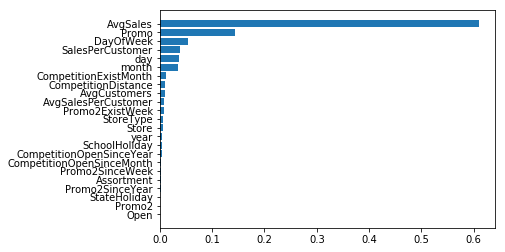

In [160]:
plot_importance(DT)


## 使用 Adaboost 模型训练测试

In [161]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Ada_DT = AdaBoostRegressor(DecisionTreeRegressor())

Ada_DT.fit(X_train,y_train)
y_pre = Ada_DT.predict(X_test)

score(Ada_DT,X_train,y_train,y_test,y_pre)

Mean -0.17234563163659944
Variance 0.0034465477037899763
RMSPE 0.12187239173683576


In [162]:
for feature in test:
    print('{} 唯一值数量:'.format(feature),len(test[feature].unique()))

Id 唯一值数量: 41088
Store 唯一值数量: 856
DayOfWeek 唯一值数量: 7
Date 唯一值数量: 48
Open 唯一值数量: 3
Promo 唯一值数量: 2
StateHoliday 唯一值数量: 2
SchoolHoliday 唯一值数量: 2


In [163]:
test.Open.unique()

array([ 1., nan,  0.])

In [164]:
#test中的NaN用1填充。一定要营业的商店才有预测的意义
test.fillna(1,inplace = True)

In [165]:
test.Open.unique()

array([1., 0.])

In [166]:
check_test = pd.merge(test,store_new,on='Store',how ='left')


In [167]:
for feature in check_test:
    print('{} 唯一值数量:'.format(feature),len(check_test[feature].unique()))

Id 唯一值数量: 41088
Store 唯一值数量: 856
DayOfWeek 唯一值数量: 7
Date 唯一值数量: 48
Open 唯一值数量: 2
Promo 唯一值数量: 2
StateHoliday 唯一值数量: 2
SchoolHoliday 唯一值数量: 2
AvgSales 唯一值数量: 856
AvgCustomers 唯一值数量: 855
AvgSalesPerCustomer 唯一值数量: 856
StoreType 唯一值数量: 4
Assortment 唯一值数量: 3
CompetitionDistance 唯一值数量: 555
CompetitionOpenSinceMonth 唯一值数量: 13
CompetitionOpenSinceYear 唯一值数量: 24
Promo2 唯一值数量: 2
Promo2SinceWeek 唯一值数量: 22
Promo2SinceYear 唯一值数量: 8
PromoInterval 唯一值数量: 4


In [168]:
# 真正test集上进行结果测试

test_feature = creat_feature(test,store_new)



TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [ ]:
check_test.StoreType.unique()

In [ ]:
check_test.Assortment.unique()

In [ ]:
check_test.StateHoliday.unique()

In [ ]:
#输出结果

y_test_pre = Ada_DT.predict(test_feature[X])


In [ ]:
# 将实际测试集的结果输出

df = pd.DataFrame({"Id":range(1,len(test) + 1),'Sales':y_test_pre})
df.to_csv('submission_Ada.csv',index = False)